<a id='0'></a>
# Playground Series - Season 3, Episode 26 (+EDA)
**Our Goal:** For this Episode of the Series, our task is to use a multi-class approach to predict the the outcomes of patients with cirrhosis.

# Easy Navigation

- [1- Data Exploration](#1)
- [2- Explanatory Data Analysis (EDA)](#2)
    - [2.0- Get the data ready for EDA](#2-0)
    - [2.1- Categorical Features](#2-1)
        - [2.1.1- Categorical features Counts/Distributions](#2-1-1)
        - [2.1.2- Tabular Relationship](#2-1-2)
        - [2.1.3- Visualization of Tabular Frequency of Features Vs Status](#2-1-3)
    - [2.2- Numeric Features](#2-2)
- [3- Feature Engineering](#3)
- [4- Modeling](#4)
    - [4.1- Model Construction](#4-1)
    - [4.2- Model Utilization & Submission](#4-2)

In [1]:
# import required libraies/dependencies
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from warnings import simplefilter
simplefilter('ignore')

<a id='1'></a>
# 1- Data Exploration

**Files**<br>
- train.csv - the training dataset; Status is the categorical target; C (censored) indicates the patient was alive at N_Days, CL indicates the patient was alive at N_Days due to liver a transplant, and D indicates the patient was deceased at N_Days.
- test.csv - the test dataset; your objective is to predict the probability of each of the three Status values, e.g., Status_C, Status_CL, Status_D.
sample_submission.csv - a sample submission file in the correct format

In [2]:
# load datasets
df_train = pd.read_csv('../Data/train.csv', index_col=0)
df_test = pd.read_csv('../Data/test.csv', index_col=0)

In [3]:
df_train.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
id,,,,,,,,,,,,,,,,,,,
0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C


In [6]:
print(f'The training set contains {df_train.shape[0]} rows and {df_train.shape[1]} columns.')

The training set contains 7905 rows and 19 columns.


In [7]:
# Combine the training and the test sets to do some preprocessing.
df_both = pd.concat([df_train, df_test])

---

<a id='2'></a>
# 2- Explanatory Data Analysis (EDA)

**In this section, we will first go through all features one by one, and then we will see the relationships among features themselves and the target variable**

<a id='2-0'></a>
## 2.0- Intro for EDA

In [8]:
# extract categorical and numerical features
cate_features = [
    'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Stage']
numeric_features = list(set(df_train.columns)  - set(cate_features) - set(['Status']))

In [28]:
## utils/functions

# funtion to draw a pie plot regarding a features counts
def draw_count_pie(df, feature):
    explode = [0]*df[feature].value_counts().shape[0]
    explode[0] = 0.1
    plt.pie(
        x = df[feature].value_counts(),
        labels=df[feature].value_counts().index,
        autopct='%1.1f%%',
        explode=explode,
        shadow=True,
        startangle=0
    )
    plt.title(f'{feature} Counts', fontdict={'fontsize': 18})
    
# draw a countplot of a categorical variable along with how it effects the target variable
def draw_cate_vs_target(df, feature):
    plt.grid(True)
    ax = sns.countplot(data=df, x=feature , hue='Status')
    ax.set_title(f'{feature} counts vs Status', fontdict={'fontsize': 18})

# display tabular relationship between a numeric feature and Status
def display_tabular_relationship_cate_target(df, feature):
    display(pd.crosstab(
        index=df['Status'],
        columns=df[feature],
        normalize='columns'
    ))
    
# draw distribution plot for a numeric feature
def draw_numeric_dist(df, feature):
    sns.kdeplot(df[feature]) 
    ax = sns.distplot(df[feature])
    ax.set_title(f'{feature} Distribution', fontdict={'fontsize': 18})

# draw boxen plot for a numeric feature vs Status
def draw_numeric_target_violin(df, feature):
    ax = sns.violinplot(data=df, x='Status', y=feature)
    ax.set_title(f'{feature} VS Status', fontdict={'fontsize': 18})


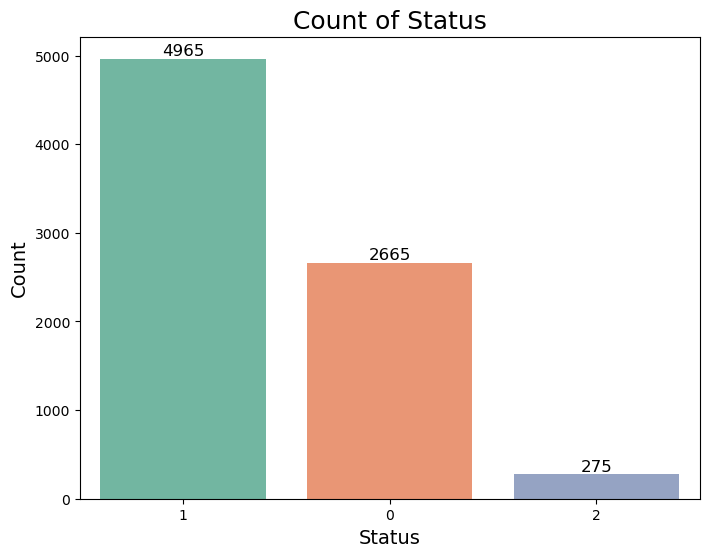

In [29]:
# Count the occurrences of each status category
status_counts = df_train['Status'].value_counts()

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.set_palette('Set2')
sns.countplot(x='Status', data=df_train, order=status_counts.index)
plt.title('Count of Status', fontsize=18)
plt.xlabel('Status', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Add labels to the bars
for i, count in enumerate(status_counts):
    plt.text(i, count, count, ha='center', va='bottom', fontsize=12)

plt.show()

<a id='2-1'></a>
## 2.1- Categorical Features

<a id='2-1-1'></a>
### 2.1.1- Categorical features Counts/Distributions

**NOTE:**<br>
In this section we will visualize how categorical features are distributed. <br>
I used Pie charts so as to help readers to conveniently identify the followings about categorical features:
- How many & which values a particular feature contains
- the most frequent value (a.k.a Mode)
- the least frequent value
- the percentage of occurance of each value


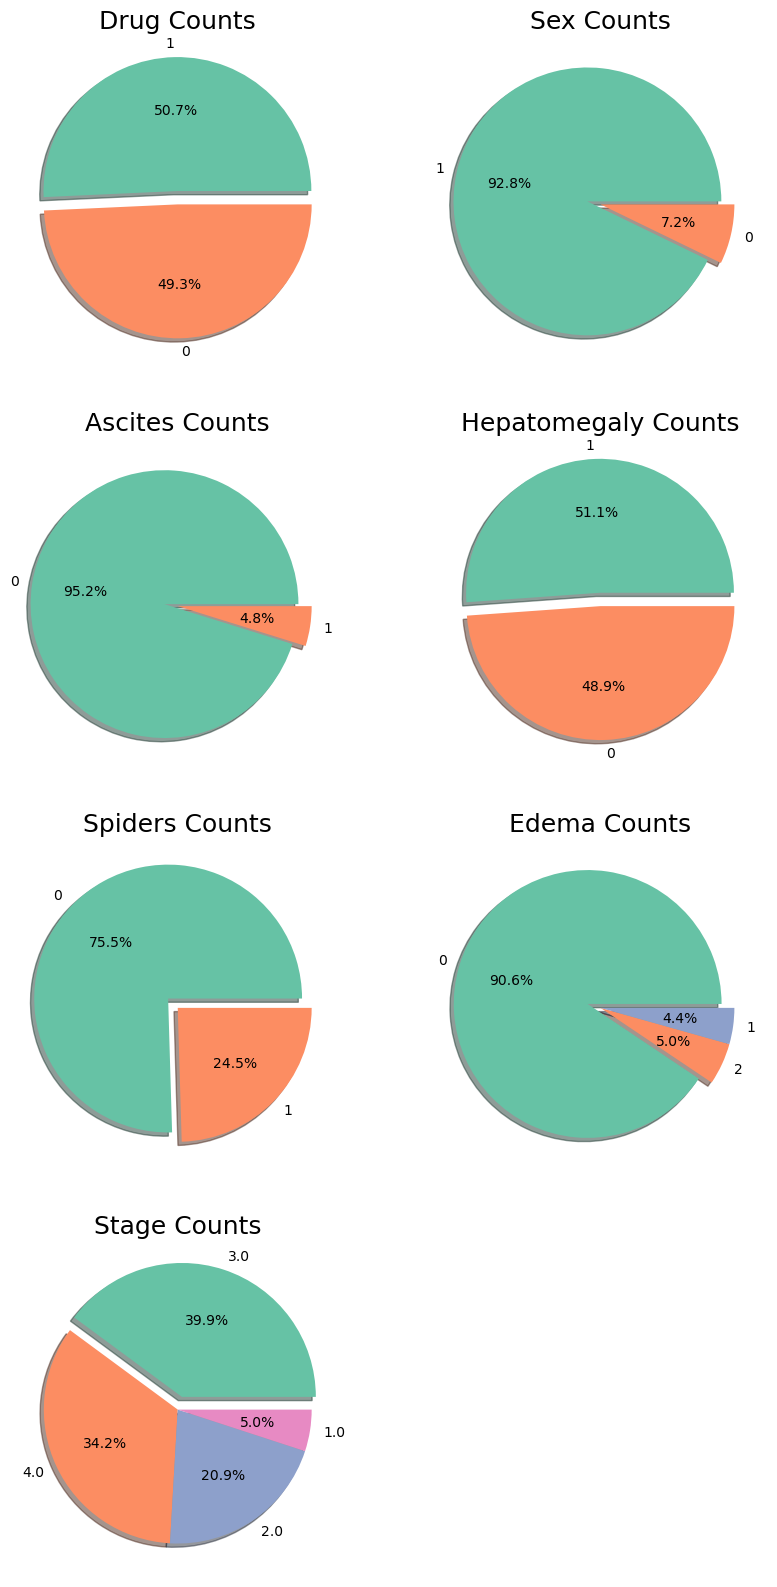

In [30]:
# draw the pie plots for all categorical features counts
plt.figure(figsize=(10, 20))
sns.set_palette('Set2')

for i, feature in enumerate(cate_features):
    plt.subplot(len(cate_features)//2+1, 2, i+1)
    draw_count_pie(df_train, feature)
    
plt.show()    

Above-displayed figures are quite self-explaining. Hence, I leave it to you to look at them and grasp how particular features are distributed.<br>
We will use these plots in feature engineering section as well.

---

<a id='2-1-2'></a>
### 2.1.2- Cross Tabulation Relationships

**NOTE:**<br>
Using cross tabular relationships, we can easily identify how particular features have an impact on each other. In this case, we use it to determine how accurance of a particular value of a feature have effected the target variable.<br>
The columns in each chart bellow represent the values of a particular feature. The sum of each column is equal to one. Furthermore, Each chart bellow contains two rows. And the intersection of each column and the first row represents the percentage of occurance of the corresponding column which has NOT resulted in an attrition; but the intersection of each column and the second row represents the percentage of occurance of the corresponding column which has resulted in an attrition. 

In [12]:
# display the cross tabular relationships of categorical features and Status
print('           *************START***********             \n\n\n')
for i, feature in enumerate(cate_features):
    print(f'{i+1}: {feature} and Status')
    display_tabular_relationship_cate_target(df_train, feature)
    print(' '*10+'*'*10+'\n\n')

           *************START***********             



1: Drug and Status


Drug,D-penicillamine,Placebo
Status,,
C,0.617458,0.638404
CL,0.038768,0.030923
D,0.343774,0.330673


          **********


2: Sex and Status


Sex,F,M
Status,,
C,0.645447,0.404218
CL,0.034215,0.042179
D,0.320338,0.553603


          **********


3: Ascites and Status


Ascites,N,Y
Status,,
C,0.656478,0.065789
CL,0.035748,0.015789
D,0.307774,0.918421


          **********


4: Hepatomegaly and Status


Hepatomegaly,N,Y
Status,,
C,0.821641,0.443097
CL,0.028216,0.041069
D,0.150142,0.515834


          **********


5: Spiders and Status


Spiders,N,Y
Status,,
C,0.716058,0.357401
CL,0.032350,0.042290
D,0.251592,0.600309


          **********


6: Edema and Status


Edema,N,S,Y
Status,,,
C,0.676861,0.275689,0.023188
CL,0.035889,0.040100,0.005797
D,0.287250,0.684211,0.971014


          **********


7: Stage and Status


Stage,1.0,2.0,3.0,4.0
Status,,,,
C,0.884131,0.782688,0.728830,0.378468
CL,0.017632,0.028450,0.035839,0.039956
D,0.098237,0.188862,0.235331,0.581576


          **********




<a id='2-1-3'></a>
### 2.1.3- Visualization of Tabular Frequency of Features Vs Status

**NOTE:**<br>
In this section we visualize how much each categorical feature has an impact on the target variable (Status).

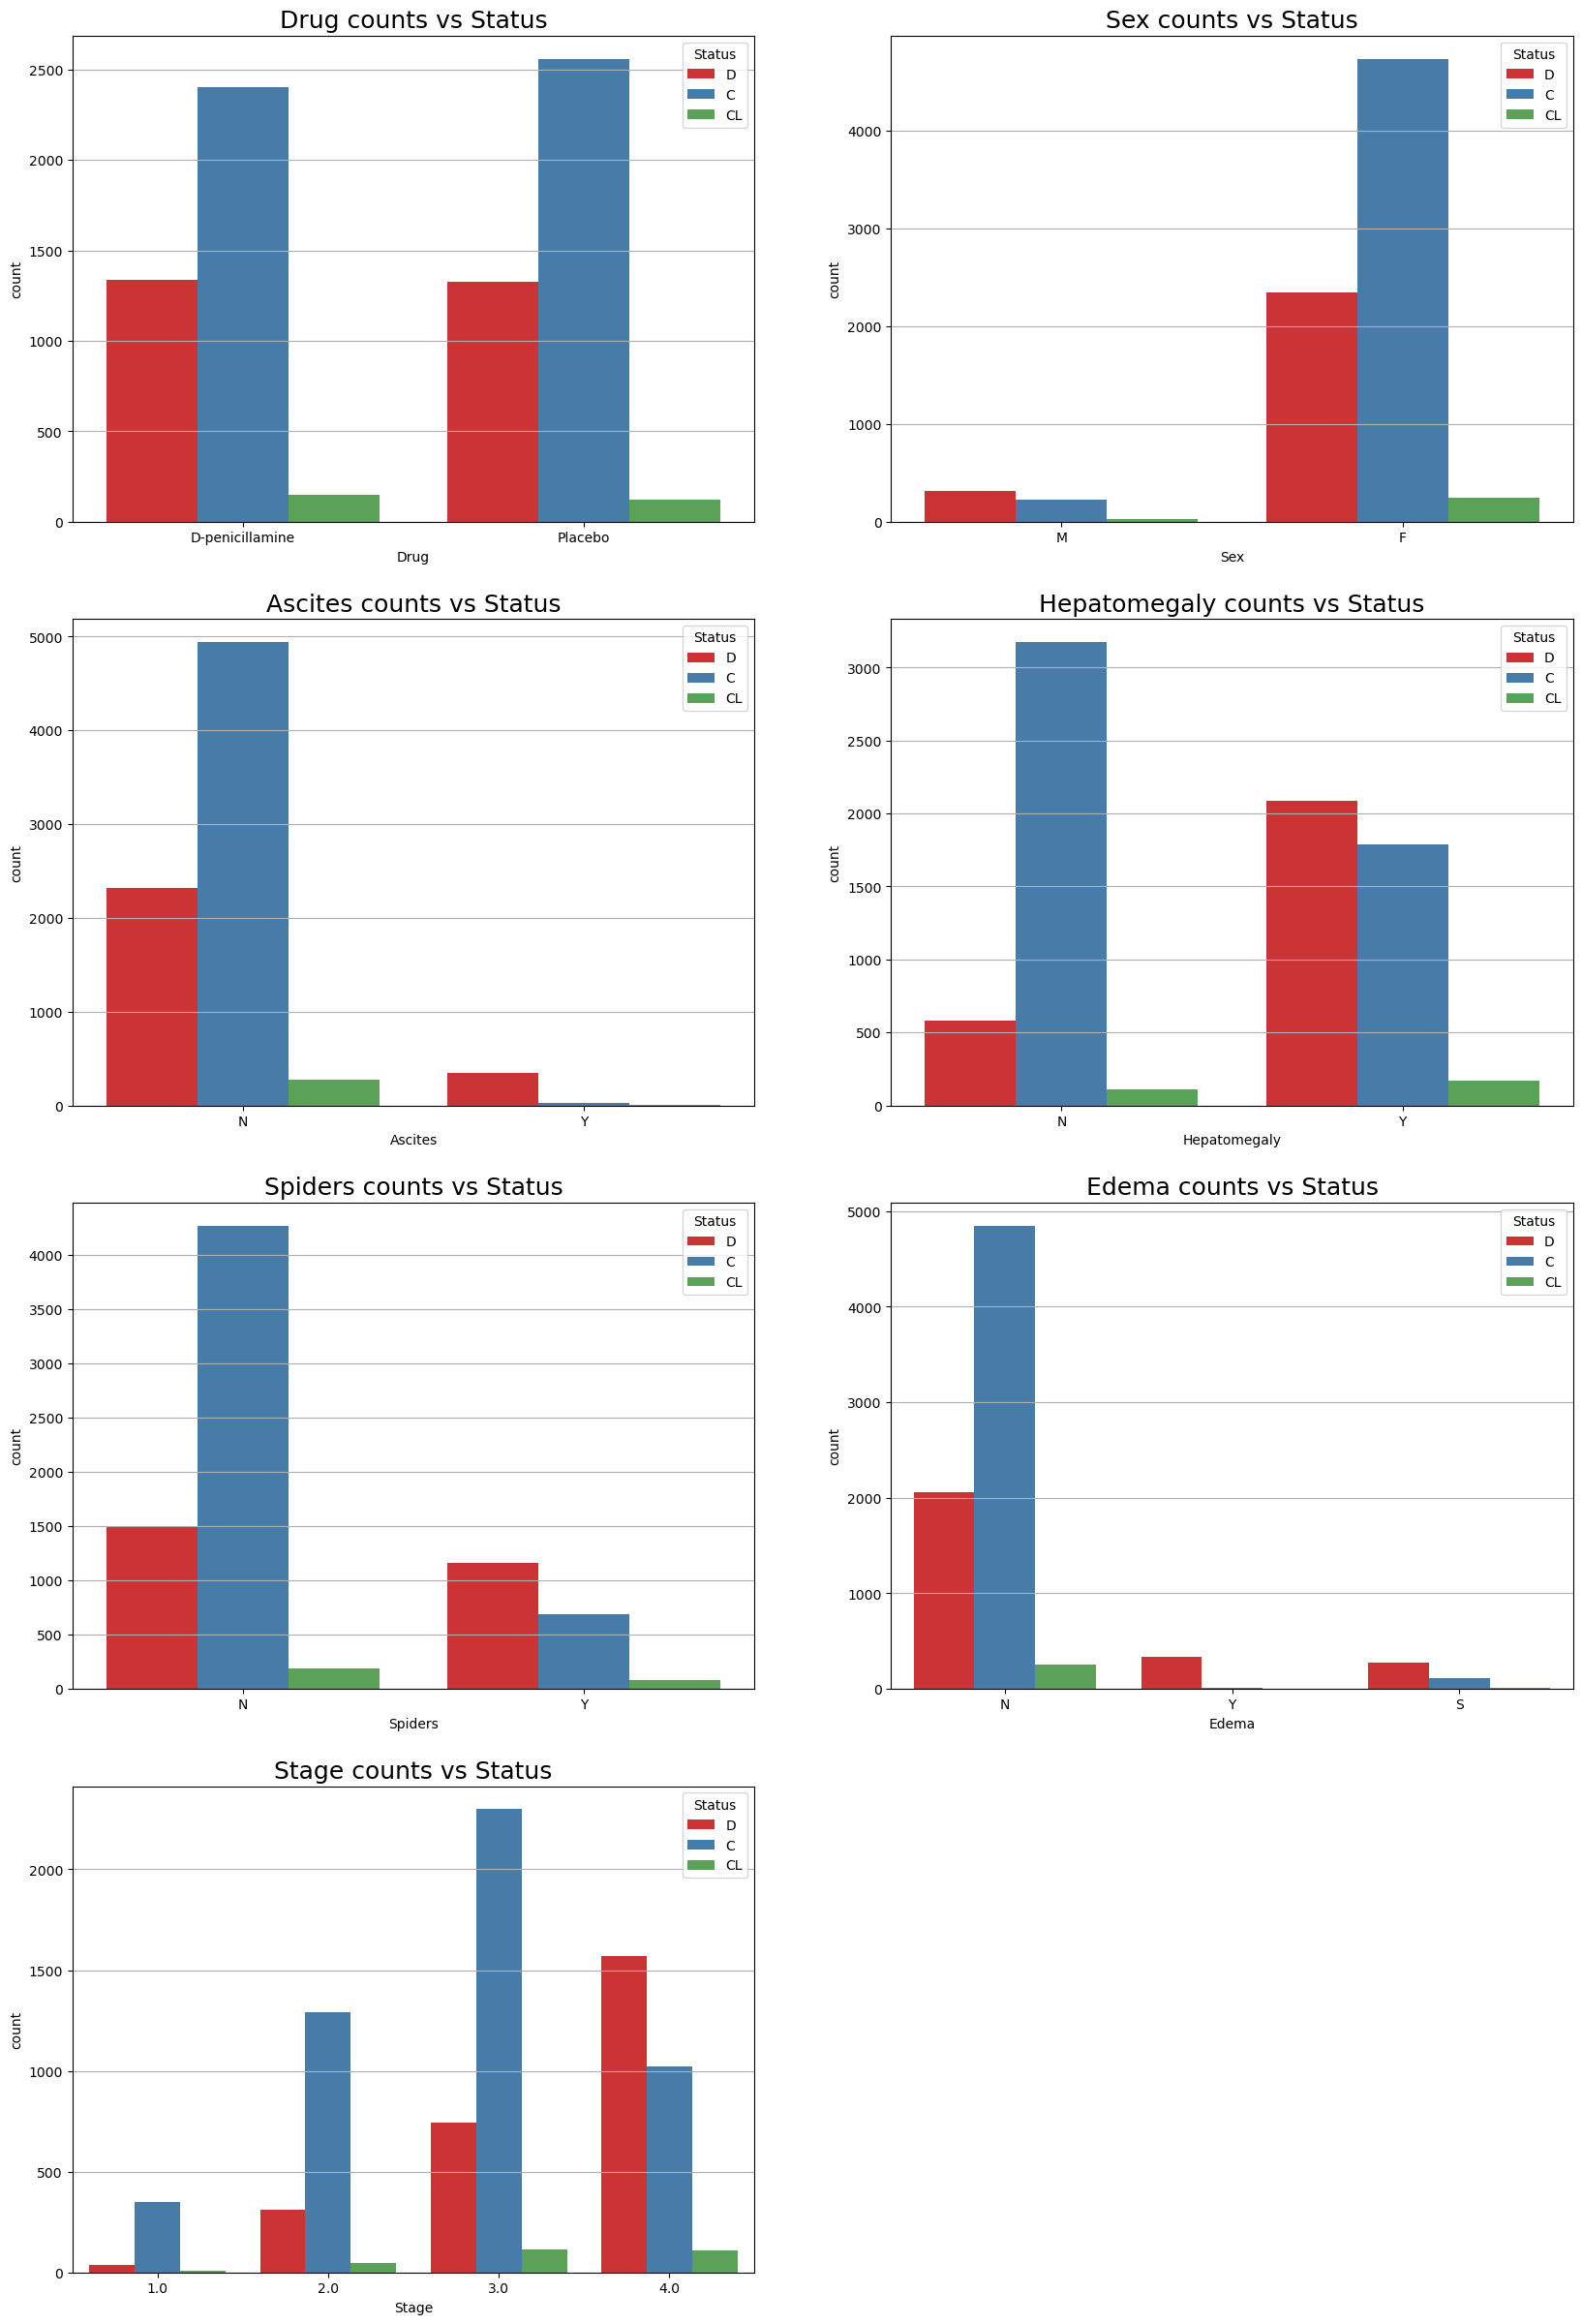

In [13]:
# draw the counts/distributions of categorical features vs the target variable
plt.figure(figsize=(20, 30))
sns.set_palette('Set1')

for i, feature in enumerate(cate_features):
    plt.subplot(len(cate_features)//2+1, 2, i+1)
    draw_cate_vs_target(df_train, feature)
    
plt.show()    

Above-displayed figures are quite self-explaining. Hence, I leave it to you to look at them and grasp how the distribution of particular features have an impact on the target variable.<br>


---

<a id='2-2'></a>
## 2.2- Numeric features

**NOTE:**<br>
In this section we will visualize how each numeric feature is distributed, and how the distribution of each particular feature has an impact on the target variable (Status).

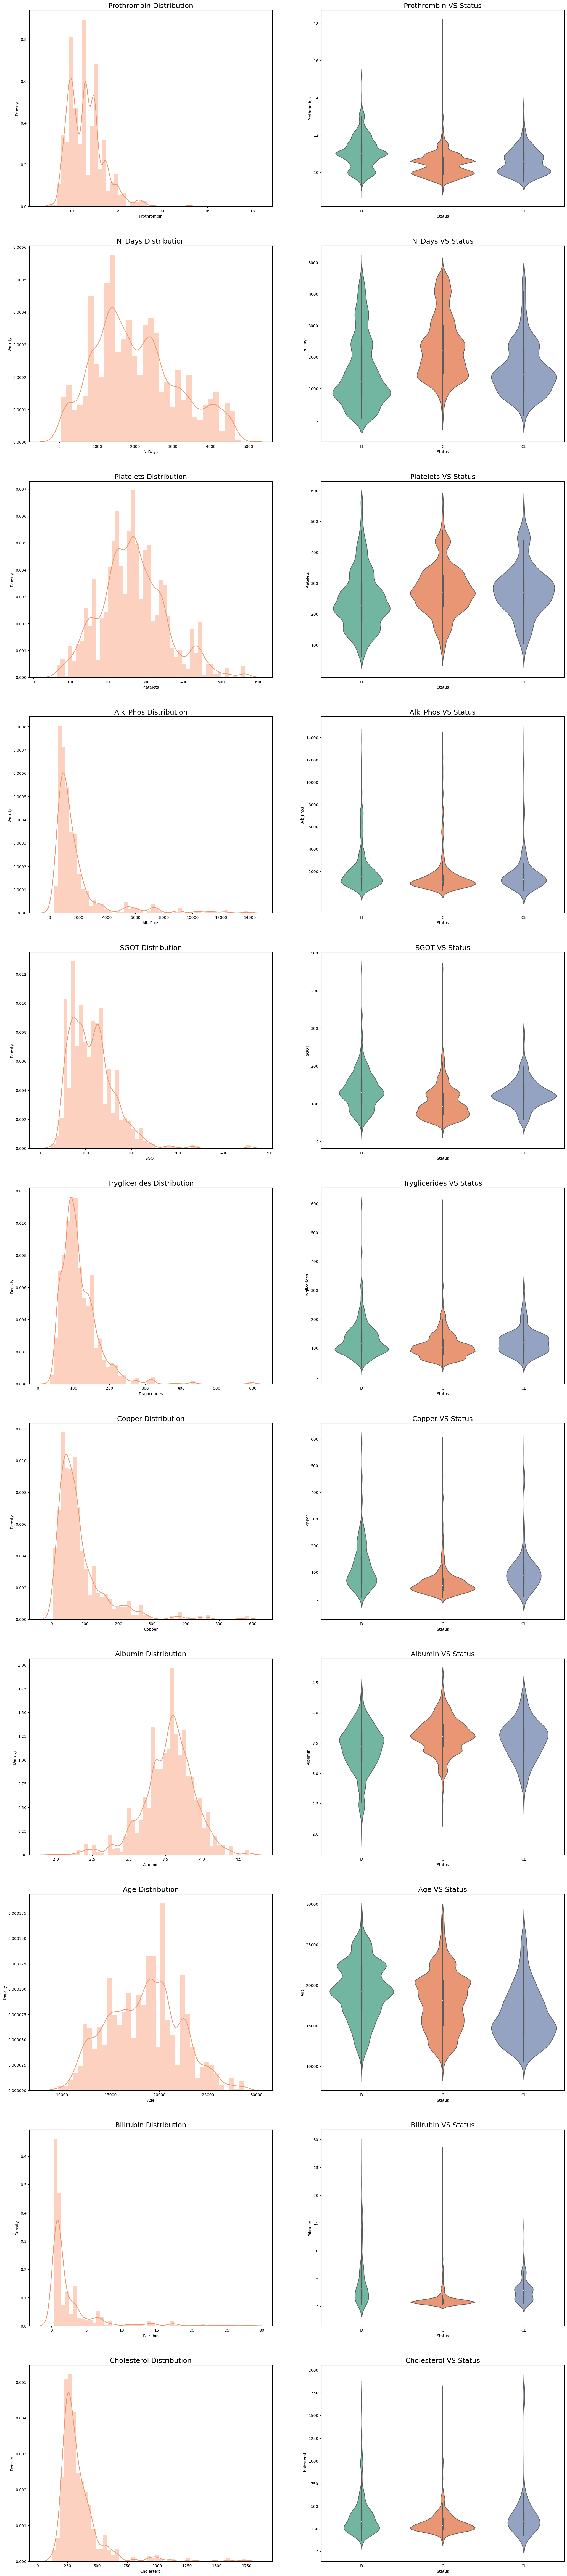

In [14]:
# draw some plots for all numeric features [+ vs Status]
plt.figure(figsize=(25, 120))
sns.set_palette('Set2')

i = 1
for feature in numeric_features:
    # dist
    plt.subplot(len(numeric_features), 2, i)
    draw_numeric_dist(df_train, feature)
    # box
    plt.subplot(len(numeric_features), 2, i+1)
    draw_numeric_target_violin(df_train, feature)
    i += 2
    
plt.show()    

Above-displayed figures are quite self-explaining. Hence, I leave it to you to look at them and grasp how particular features are distributed, and how they have an impact on the target variable.<br>
We will use these plots in feature engineering section as well.

<a id='3'></a>
# 3- Feature Engineering

What is **Feature Engineering?**<br>
> Feature engineering is a machine learning technique that leverages data to create new variables that aren’t in the training set. It can produce new features for both supervised and unsupervised learning, with the goal of simplifying and speeding up data transformations while also enhancing model accuracy. (https://towardsdatascience.com/what-is-feature-engineering-importance-tools-and-techniques-for-machine-learning-2080b0269f10)

In [15]:
# Encode the categorical features into numbers
# Drug
df_both['Drug'] = df_both['Drug'].map({
    'D-penicillamine': 0,
    'Placebo': 1
}).astype('int')

# Sex
df_both['Sex'] = df_both['Sex'].map({
    'M': 0,
    'F': 1,
}).astype('int')

# Ascites
df_both['Ascites'] = df_both['Ascites'].map({
    'N': 0,
    'Y': 1
}).astype('int')

# Hepatomegaly
df_both['Hepatomegaly'] = df_both['Hepatomegaly'].map({
    'N': 0,
    'Y': 1
}).astype('int')

# Spiders
df_both['Spiders'] = df_both['Spiders'].map({
    'N': 0,
    'Y': 1
}).astype('int')

# Edema
df_both['Edema'] = df_both['Edema'].map({
    'N': 0,
    'Y': 1,
    'S': 2
}).astype('int')


**Create some new features**:<br>
- The `Bilirubin_to_Albumin_Ratio` feature is calculated as the ratio of `Bilirubin` to `Albumin`. It provides insights into the liver's synthetic and excretory functions.

- The `Disease_Severity_Score` feature represents the overall severity of cirrhosis by summing up the presence of conditions such as Ascites, Hepatomegaly, and Spiders.

- The `Liver_Health_Index` feature is calculated as the average of liver function tests such as Bilirubin, SGOT, Alk_Phos, and Prothrombin. It provides an index of overall liver health.

- The `Metabolic_Index` feature represents the metabolic status of patients with cirrhosis. It is calculated as the average of relevant biomarkers such as Cholesterol, Tryglicerides, and Albumin.

In [16]:
# Liver function ratios
df_both['Bilirubin_to_Albumin_Ratio'] = df_both['Bilirubin'] / df_both['Albumin']

# Disease severity score
df_both['Disease_Severity_Score'] = df_both['Ascites'] + df_both['Hepatomegaly'] + df_both['Spiders']

# Liver health index
df_both['Liver_Health_Index'] = (df_both['Bilirubin'] + df_both['SGOT'] + df_both['Alk_Phos'] + df_both['Prothrombin']) / 4

# Metabolic index
df_both['Metabolic_Index'] = (df_both['Cholesterol'] + df_both['Tryglicerides'] + df_both['Albumin']) / 3

# N_Months & N_Years
df_both['N_Months'] = df_both['N_Days']/30
df_both['N_Years'] = df_both['N_Days']/365
#Age_Years
df_both['Age_Year'] = df_both['Age']/365
df_both.shape

(13176, 26)

In [17]:
df_both.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,...,Prothrombin,Stage,Status,Bilirubin_to_Albumin_Ratio,Disease_Severity_Score,Liver_Health_Index,Metabolic_Index,N_Months,N_Years,Age_Year
id,,,,,,,,,,,,,,,,,,,,,
0,999,0,21532,0,0,0,0,0,2.3,316.0,...,9.7,3.0,D,0.686567,0,448.2000,127.450000,33.300000,2.736986,58.991781
1,2574,1,19237,1,0,0,0,0,0.9,364.0,...,11.0,3.0,C,0.254237,0,396.6875,151.846667,85.800000,7.052055,52.704110
2,3428,1,13727,1,0,1,1,1,3.3,299.0,...,11.7,4.0,D,0.929577,2,290.8375,117.516667,114.266667,9.391781,37.608219
3,2576,1,18460,1,0,0,0,0,0.6,256.0,...,10.7,3.0,C,0.171429,0,433.9000,118.500000,85.866667,7.057534,50.575342
4,788,1,16658,1,0,1,0,0,1.1,346.0,...,10.6,4.0,C,0.301370,1,329.5625,148.550000,26.266667,2.158904,45.638356


In [18]:
# re-assign df_train and df_test to reflect the changes we have made.
df_train = df_both.iloc[:df_train.shape[0]]
df_test = df_both.iloc[df_train.shape[0]:].drop('Status', axis=1)

<a id='4'></a>
# 4- Modeling

<a id='4-1'></a>
## 4.1- Model Construction

In [19]:
# Encode the target variable
df_train['Status'] = df_train['Status'].map({
    'D': 0,
    'C': 1,
    'CL': 2
}).astype('int')

In [20]:
# Separate the features from the target variable
X = df_train.drop('Status', axis=1)
y = df_train['Status'].astype('int')

In [21]:
# Split the data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=1)

In [22]:
from lightgbm import LGBMClassifier
# Define the LightGBM classifier
lgbm = LGBMClassifier()
# Fit the model to the training data
lgbm.fit(X_train, y_train)

LGBMClassifier()

In [23]:
from sklearn.metrics import confusion_matrix
y_pred_lgbm = lgbm.predict(X_test)
print('LGBM CM: ')
display(confusion_matrix(y_test, y_pred_lgbm))

LGBM CM: 


array([[214,  71,   1],
       [ 41, 439,   2],
       [  5,  14,   4]], dtype=int64)

In [24]:
# compute the loggloss on the test set
from sklearn.metrics import log_loss
lgbm_preds = lgbm.predict_proba(X_test)
# Calculate the log loss
lgbm_logloss = log_loss(y_test, lgbm_preds)
print(f"Log Loss: {lgbm_logloss:.4f}")

Log Loss: 0.4654


<a id='4-2'></a>
## 4.2- Prediction & Submission

In [25]:
# predict on the test set
# classification
lgbm_preds = lgbm.predict_proba(df_test)

In [26]:
# create the submission file
sb_file = pd.read_csv('../Data/sample_submission.csv')
sb_file.Status_D = lgbm_preds[:, 0]
sb_file.Status_C = lgbm_preds[:, 1]
sb_file.Status_CL = lgbm_preds[:, 2]
sb_file.head()

,id,Status_C,Status_CL,Status_D
0,7905,0.535462,0.020300,0.444238
1,7906,0.822023,0.075588,0.102389
2,7907,0.014440,0.001270,0.984290
3,7908,0.984763,0.000835,0.014402
4,7909,0.892030,0.007312,0.100658


In [1]:
# write to a file
sb_file.to_csv('./submission.csv', index=False)
print('Done...')

NameError: name 'sb_file' is not defined

# Thank you :)
By: [Hikmatullah Mohammadi](https://www.kaggle.com/hikmatullahmohammadi) <br>

[Go to top](#0)